# Macchine di Boltzmann ristrette

## Introduzione

In questo lavoro studieremo uno specifico tipo di rete neurali chamata **Boltzmann machines**, un tipo di rete resa popolare da Geoffrey Hinton nel 1985.<br> Una macchina di Boltzmann è un modello, comprensivo di certi parametri, che può essere utilizzato per cogliere aspetti importanti di una distribuzione incognita (*target distribution*) partendo solo da un campione di quest'ultima. <br> Addestrare una macchina di Boltzmann significa adattare i suoi parametri in modo che la distribzione di probabilità da essa rappresentata interpoli i dati di addestramento al meglio possibile. L'addestramento è un processo piuttosto impegnativo da un punto di vista computazionale per questo motivo spesso vengono imposte delle restrizioni alla rete su cui si sta lavorando. Questo ci porta alle **Restricted Boltzmann machines**.

Nelle macchine di Boltzmann si possono riscontare due tipologie di unità (*neuroni o nodi*), quelle **visibili** e quelle **nascoste**. Le prime costituiscono le componenti di un'osservazione, ad esempio come vedremo più avanti possono essere associate al singolo di pixel di un immagine, e per ciò vengono inserite dall'utente; le unità nascoste ci danno invece una modellizzazine delle dipendenze che intercorrono tra le componenti della nostra osservazione, per questo motivo vengono viste come dei rivelatori delle caratteristiche dei dati.

<div>
<img src = "images/RBM1.png" width = "500px">
</div>

Come possiamo osservare dall'immagine, le macchine di Boltzmann ristrette possono essere viste come dei grafi bipartiti completi, dove il primo insieme dei vertici è composto dai neuroni visibili, il secondo insieme dai neuroni nascosti e i lati corrispondono alle connsessioni sinaptiche. <br>


Sia $W = [w_{ij}]$ la matrice delle connessioni tra le unità, dove $w_{ij}$ è il peso della connessione tra il nodo visibile i-esimo e il nodo nascosto j-esimo, per semplicità richiediamo che:
- $w_{ij} = w_{ji}$, ovvero che $W$ sia simmetrica
- $w_{ij} = 0 \quad\forall i$., ovvero non ci siano autointerazioni

Inoltre ad ogni layer associamo un bias, chiamiamo $v_0 = [v_0^i]$ il vettore dei bias dei nodi visibili e  $h_0 = [h_0^i]$ il vettore dei bias dei nodi nascosti. 

Un'altra caratteristica fondamentale delle RBM, è che sono dei modelli basati sull'energia della configurazione congiunta dei nodi visibili e nascosti. Per cogliere le dipendenze si associa quindi un'energia scalare a ciascuna configurazione delle variabili, che serve come misura di compatibilità. Un'energia elevata significa una cattiva compatibilità. Un modello basato sull'energia cerca sempre di ridurre al minimo una funzione energetica,tale funzione per le RBM è definita come:
$$E(v,h) = -\sum_{i \in visible}v_0^iv_i-\sum_{j \in hidden}v_0^jh_j-\sum_{i,j}v_ih_jw_{ij}=-v_O^T\,v-h_0^T\,h-v^T\,Wh$$
La rete associa quindi una probabilità ad ogni coppia possibile (v,h) utilizzando questa funzione d'energia:
$$p(v,h) = \frac{1}{Z}e^{-E(v,h)}$$
dove $Z = \sum_{v,h}e^{-E(v,h)}$ è la funzione di normalizzazione (*in fisica tale distribuzione è conosciuta come la distribuzione di Boltzmann che dà la probabilità che una particella possa essere osservata nello stato con l'energia $E$* ). Inoltre la rete assegna una probabilità ad ogni vettore visibile v, che siottiene sommando su tutti i vettori degli stati nascosti:
$$p(v) = \frac{1}{Z}\sum_he^{-E(v,h)} = \frac{\sum_he^{-E(v,h)}}{\sum_{v,h}e^{-E(v,h)}}$$

Gli stati dei due layer possono assumere valori in {1,0} che corrispondono respettivamente a stati attivati e non. La probabilità che un'unità dello strato nascosto sia attiva conoscendo gli stati dell'input layer (e viceversa) sono:
- $\,\,\mathbb{P} (h_i = 1 \,|\, v) = \sigma(v\cdot W+h_0^i)$
- $\,\,\mathbb{P} (v_i = 1 \,|\, h) = \sigma(h\cdot W^T+v_0^i)$

dove $\sigma(x)=\frac{1}{1+e^{-x}}$ è la funzione logistica.

### Modello generativo

Eseguedno un addestramento ben riuscito , una RBM fornisce una rappresentazione molto buona della distribuzione che sottende i dati di training, in questo modo la  nostra rete può essere vista come un **modello generativo** che permette di campionare nuovi dati a partire dalla distribuzione appresa. Avere un modello generativo rende possibili delle utili applicazioni, ad esempio si può pensare di integrare alcune unità visibili corrispondenti ad un'osservazione parziale (i.e. un immagine corrotta) e successivamente si può cercare di completare l'osservazione.

<div>
<img src = "images/generativeRBM.png" width = "500px">
</div>

Il task di questo particolare modello di RBM è quello di imparare una distribuzione $q(x)$, ovvero vogliamo aggiustare i paramerti al fine di ottenere $p_{W,\theta}(v) \sim q(x)$.

### Classificatori

Grazie al loro essere modelli generativi, le RBM possono essere utilizzate come dei **classificatori**. Si consideri un'applicazione di questo tipo: la macchina di Boltzmann ristretta viene addestrata per apprendere la distribuzione di probabilità congiunta $q(x,y)$ dei dati in ingresso (variabili esplicative) e delle corrispondenti "eitchette" (label), entrambe rappresentate dalle unità visibili della RBM. Successivamente, un nuovo esempio di *pattern* d'ingresso, privo di label, viene passato in input al modello allenato e questo sarà in grado di predire l'etichetta corrispondente.

<div>
<img src = "images/classification.png" width = "500px">
</div>

### Il processo d'apprendimento

Il nostro obiettivo ora è quello di aggiustare i parametri, pesi e bias, in modo tale che la distribuzione rappresentata sia la migliore approssimazione possibile della distribuzione target. Come possiamo misurare la distanza tra le due distribuzioni? L'approccio che useremo sfrutta la **distanza diKullback-Leibler**, quindi cerchiamo quindi di ridurre al minimo la funzione: $$D(q||p_{\lambda}) = \sum_vq(v)\log\Big(\frac{q(v)}{\sum_hp_{\lambda}(v,h)}\Big) =  \sum_vq(v)\Big[\log q(v)-\log\sum_hp_{\lambda}(v,h)\Big]=  \sum_vq(v)\Big[\log Z(v)-\log Z\Big]$$
dove $\lambda$ è il vettore dei parametri.

Ora per calcolare il minimo di tale funzione si usa l'algoritmo di **discesa del gradiente**. Necessitiamo quindi di calcolare il gradiente di tale funzione e quindi le sue derivate parziali:
- $\begin{array}{rl}
q(v)\frac{\partial}{\partial \lambda}\log Z & = \frac{1}{Z}\sum q(v)\frac{\partial}{\partial \lambda}e^{-E(v,h)} = \sum q(v)\frac{e^{-E(v,h)}}{Z}\frac{\partial}{\partial \lambda}E(v,h) \\ & = \sum p_\lambda(v,h)\frac{\partial}{\partial \lambda}E(v,h) = <\frac{\partial}{\partial \lambda}E_\lambda(v,h)>_\lambda \end{array}$


- $\begin{array}{rl}q(v)\frac{\partial}{\partial \lambda}\log Z(v) &  = \frac{1}{Z(v)}\sum q(v)\frac{\partial}{\partial \lambda}e^{-E(v,h)}= \sum q(v)\frac{e^{-E(v,h)}}{Z(v)}\frac{\partial}{\partial \lambda}E(v,h)\\ & = \sum q(v)p_\lambda(h|v)\frac{\partial}{\partial \lambda}E(v,h)  = <\frac{\partial}{\partial \lambda}E_\lambda(v,h)>_{v,\lambda}\end{array}$

Mettendo tutto insieme otteniamo una formula per il gradiente della funzione di perdita:
 $$\frac{\partial}{\partial\lambda}D(q||p_{\lambda}) \propto \mathbb{E}_{v,h}\Bigg(\frac{\partial}{\partial \lambda}E\lambda(v,h)\Bigg)-\mathbb{E}_\lambda\Bigg(\frac{\partial}{\partial \lambda}E(v,h)\Bigg)$$
da cui possiamo ricavare la learning rule dell'algoritmo di training. Osserviamo che il primo termine da calcolare è immediato mentre il secondo è ben più complicato, per questo utilizzeremo un metodo meccanico statistico per ottenerlo.

### Contrastive divergence 

I metodi Monte Carlo basati sulle catene di Markov sono degli algoritmi utilizzati per il campionamento di una distribuzione di probabilità, basati sulla costruzione di catene di Markov aventi come distribuzione stazionaria la distribuzione desiderata. Infatti dopo aver simulato un gran numero di passi della catena si possono quindi usare i valori estratti come campione della distribuzione voluta. <br>

<div>
<img src = "images/gibbsSampling.png" width = "500px">
</div>

Quindi aprrossimare il secondo termine del gradiente ci richiederebbe di percorrere una catena di Markov finchè non viene raggiunta la distribuzione stazionaria (dove raggiungo il minimo dell'energia e quindi l'equilibrio), ciò però richiede un grosso sforzo computazionalmente parlando. Per ovviare a questo problema sfrutteremo il campionamento di Gibbs che è sempre un metodo Monte Carlo basato su catene di Markov, ma che viene sfruttato in particolare per ottenere una sequenza di osservazioni che sono approssimate da una specifica distribuzione quando un campionamento diretto è difficile. <br>

La catena di Gibbs viene inizializzata con un esempio del training set $v_0$ e dopo k-passi si ottiene il campione $v_k$. Ogni passo consiste di due fasi:
1. campionamento di $h(t)$ sfruttando la nota distribuzione $p(h|v(t))$
2. campionamento di $v(t+1)$ sfruttando la distribuzione appena calcolata $p(v|h(t))$

la domanda che potrebbe sorgere è quanti passi dobbiamo percorrere prima di ottenere un buon campione, G. Hinton ha dimostrato che anche un solo step è sufficiente ad ottenere una buona approssimazione.

Siamo ora in grado di calcolare tutti i termini della learning rule, possiamo quindi aggiornare i parametri, l'algoritmo che si occupa di ciò è detto **Contrastive divergence**. 
$$CD_k(\lambda,v^{(0)}) = \sum_h p(h|v^{(k)})\frac{\partial}{\partial \lambda}E(v^{(k)},h) - \sum_h p(h|v^{(0)})\frac{\partial}{\partial \lambda}E(v^{(0)},h)$$

## Implementazione

All'intermo della funzione *\_init\_* vengono inizializzati tutti i parametri che bisognerà ottimizzare. In particolar modo il **learning rate** e il **numero di iterazioni** dell'allenamento. <br> Osserviamo che il **numero dei nodi visibili** e il **numero delle label**, vengono prefissati a priori quando viene creata la macchina, in quanto potremo lavorare solamente con immagini con 28x28 pixel e il numero dei pattern da riconoscere viene stabilito precedentemente.<br>Inoltre è importante sottolineare che la matrice dei pesi **W** nella funzione *\_initialize_weights* è stata inizializzata utilizzando una *distribuzione normale* con media 0 e varianca 1, mentre i vettori dei bias dei nodi visibili e dei nodi nascosti, ripsettivamene $\textbf{v}_0$ e $\textbf{h}_0$, sono inizialmente pari al vettore nullo.

Infine, tra le funzioni basilari che il modello deve necessariamente avere, troviamo *\_train* che ci permette di allenare la nostra rete sfruttando la Contrastive Divergence, algoritmo che vedremo nel dettaglio più avanti.

In [1]:
def __init__(self, n_visible, n_hidden, learning_rate = 0.1, batch_size = 1, n_iterations = 100, classifier = False, n_label = 0):
    
    self.n_visible = n_visible
    self.n_hidden = n_hidden
    self.lr = learning_rate
    self.batch_size = batch_size
    self.n_iterations = n_iterations
    
    self.training_errors = []
    self.training_reconstructions = []
    self.W = np.zeros(shape = (n_visible, self.n_hidden))
    self.v0 = np.zeros(n_visible)       # Bias visible
    self.h0 = np.zeros(self.n_hidden)   # Bias hidden

    if classifier:
        self.n_label = n_label
        self.U = np.zeros(shape = (n_label, self.n_hidden))
        self.z0 = np.zeros(n_label)
        
def _initialize_weights(self, classifier):
    self.W = np.random.normal(scale = 1, size = (self.n_visible, self.n_hidden))
    
    if classifier:
        self.U = np.random.normal(scale = 1, size = (self.n_label, self.n_hidden))

def _train(self, X, y = None, classifier = False):
    
    self._initialize_weights(classifier)
    if classifier: 
        self._CD1_Classification(X,y)
    else: self._CD1_Generative(X)

Concentriamoci sulla parte algoritmica che opera i sampling che verranno utilizzati nella funzione della Contrastive Divergence.
- *\_mean_hiddens*: è la funzione che calcola la probabilità di attivazione dell' *i_esimo neurone nascosto* $\,\,\mathbb{P} (h_i = 1 \,|\, v) = \sigma(v\cdot W+h_0^i)$
- *\_sample_hiddens*: è la funzione che dopo aver calcolato la probabilità d'attivazione dei neuroni nascosti, ne esegue il sample prendendo in riferimento una distribuzione uniforme sull'intervallo [0,1] 
- *\_sample_visibles*: è la funzione che dopo aver calcolato la probabilità d'attivazione dei neuroni visibili, $\,\,\mathbb{P} (v_i = 1 \,|\, h) = \sigma(h\cdot W^T+v_0^i)$, ne esegue il sample prendendo in riferimento una distribuzione uniforme sull'intervallo [0,1] 

Infine, poichè stiamo lavorando con stati $v,h\in{0,1}$, la funzione *\_sample* estrae randomicamente un numero tra [0,1], lo confronta con quello calcolato dalle precedenti funzioni e assegna al nodo in questione il valore 1 o 0 se il neurone è attivato o meno.

In [2]:
def _mean_hiddens(self, v):
    #Computes the probabilities P(h=1|v). 
    
    return sigma(v.dot(self.W) + self.h0)

def _sample_hiddens(self, v):
    #Sample from the distribution P(h|v).
    
    p = self._mean_hiddens(v)
    return self._sample(p)

def _sample_visibles(self, h):
    #Sample from the distribution P(v|h).
    
    p = sigma(h.dot(self.W.T) + self.v0)
    return self._sample(p)

def _sample(self, X):
    
    return X > np.random.random_sample(size = X.shape)

Come ultima funzione analizziamo quella dedicata all'ottimizzzazione dei parametri, la Contrastive Divergence. Come visto poco fa nella parte introduttiva, questo algoritmo consiste principalmente di due fasi: la prima, detta **fase positiva**,nella quale viene calcolato $\,\,\mathbb{E}_{v,j, \theta}(s_is_j)$ che abbiamo visto coincidere con la fase iniziale del Gibbs step, ovvero $\,\,\mathbb{E}_{s_{(0)}}(s_is_j)$ e successivamente la seconda fase, detta **fase negativa**, nella quale viene calcolato il ben più difficile $\,\,\mathbb{E}_{j,\theta}(s_is_j)$. Analizziamo nel dettaglio il codice.

Soffermiacosi su ciò che avviene nel ciclo for più interno, inizialmente si divide il dataset in dei batch che ad ogni iterazione prenderanno il ruolo del vettore $v_0$, dopo di che andremo a calcolarci nell'ordine il valore atteso della distribuzione dei nodi nascosti condizionata all'osservazione dei valori del nostro batch (*positive_hidden*), la correlazione positiva tra gli stati (*positive_associations*) e successivamente si calcola lo stato dei neuroni nascosti secondo la dinamica precedentemente illustrata. Con questi step la fase positiva può considerarsi conclusa.

Eseguiamo dunque il primo step della simulazione di Gibbs e calcoliamo $v_1$ (*negative_visible*), che sarà il punto di partenza per la fase negativa. Poi, allo stesso modo della fase precedente, calcoliamo il valore atteso della distribuzione dei nodi nascosti condizionata all'osservazione dei valori del vettore $v_1$ (*negative_hidden*) e infine la correlazione negativa tra gli stati (*negative_associations*).

Ora che entrambi le fasi, positiva e negativa, sono concluse possiamo aggiornare la rete neurale:
- $\Delta W = \Delta W + \epsilon\,(positive\_associations - negative\_associations)$
- $\Delta h_0 = \Delta h_0 + \epsilon\,(positive\_hidden - negative\_hidden)$
- $\Delta v_0 = \Delta v_0 + \epsilon\,(v_0 - v_1)$

dove $\epsilon$ è il learning rate.

In [3]:
def _CD1_Generative(self, X):

    for _ in tqdm(range(self.n_iterations)):
        batch_errors = []
            
        for batch in batch_iterator(X, batch_size = self.batch_size):
            #v_0 = batch 
                
            # Positive phase ---> E_v,j,o[sisj] = E_s(0)[sisj]
            positive_hidden = self._mean_hiddens(batch)  # E(h)_0=1*P(h=1|v) -0*P(h=-1|v)
            positive_associations = batch.T.dot(positive_hidden) #E(h)_0*v_0
            hidden_states = self._sample_hiddens(batch) # hidden to use in the second part of sample    
                
            # Negative phase ---> E_j,o[sisj] = E_s(inf)[sisj]
            negative_visible = self._sample_visibles(hidden_states) # v_k
            negative_hidden = self._mean_hiddens(negative_visible)   # E(h)_k=1*P(h=1|v) -0*P(h=-1|v)
            negative_associations = negative_visible.T.dot(negative_hidden) #E(h)_k*v_k
                
            self.W  += self.lr * (positive_associations - negative_associations)
            self.h0 += self.lr * (positive_hidden.sum(axis = 0) - negative_hidden.sum(axis = 0))
            self.v0 += self.lr * (batch.sum(axis = 0) - negative_visible.sum(axis = 0))

            batch_errors.append(np.mean((batch - negative_visible) ** 2))

        self.training_errors.append(np.mean(batch_errors))
            
        # Reconstruct a batch of images from the training set
        self.training_reconstructions.append(self._reconstruct(X[:25])) 
        if np.mean(batch_errors)*100 < 1: return

## Risultati

Ora che abbiamo visto come creare una macchina di Boltzmann mettiamola alla prova. Il lavoro è stato diviso in due parti, la prima in cui verrà testata la rete neurale con delle variabili Rademachers, ovvero dei vettori random $v$ tali che $v_i\in {0,1} \quad \forall i$ e successivamente con un dataset più strutturato quale il MNIST.

### Variabili Rademachers 

Per procedere con l'analisi ho deciso di lavorare su 5 pattern randomici i cui singoli pixel sono stati estratti da una distribuzione di Bernoulli con parametro $p = 0.5$, ad ogni archetipo ho poi associato un etichetta.

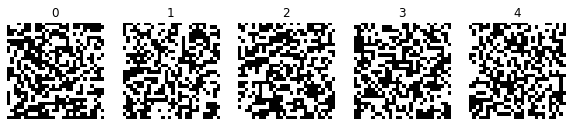

In [4]:
from utils_function import *

n_label = 5
plt.figure(figsize=(10, 10))
archetype = generateArchetype(n_label)

for i in range(len(archetype)):
    ax = plt.subplot(1, len(archetype), i+1)
    plt.imshow(archetype[i][0].reshape((28, 28)), cmap='gray')
    plt.title(archetype[i][1])
    plt.axis('off')

Una volta generati gli archetipi è stato necessario creare il vero e proprio dataset. Utilizzand la seguente funzione ho creato 2000 copie di ogni archetipo flippando ad ogni iterazione il $5\%$ dei pixel, in modo da ottenere così il dataset su cui lavorare.

In [5]:
def myDataset(a):
    copies = []
    label = []
    for i in range(len(a)):
        for _ in range(2000):
            copies.append(flipped(5,a[i][0]))
            label.append(a[i][1])
    return pd.DataFrame({'Copies':copies, 'Label':label})

df = myDataset(archetype)
data = df.sample(frac=1).reset_index(drop=True)

Successivamente ho operato un suddivisione dei dati, il $70\%$ viene utilizzato come training set mentre il restante $30\%$ come test set.

In [6]:
traindata = data.Copies[:int(0.7*len(df))]
testdata = data.Copies[int(0.7*len(df)):]

trainlabel = data.Label[:int(0.7*len(df))].tolist()
testlabel = data.Label[int(0.7*len(df)):].tolist()

traindata = np.array([traindata[i] for i in range(len(traindata))])
testdata = np.array([testdata[int(0.7*len(df))+i] for i in range(len(testdata))])

learning_rate = (0.5, 0.1, 0.01, 0.001, 0.0005, 0.0001)
n_hidden = (200, 150, 100, 50, 40, 30, 20, 10, 5)

Ottenuto il training set su cui addestrare la nostra rete neurale procediamo con la creazione del modello e contestualmente vediamo l'andamento dell'errore commesso ad ogni iterata dell'apprendimento, al variare dei parametri.

L'errore visulizzato indica l'MSE tra il vettore dei nodi visibili e quello computato con il sampling di Gibbs.

In [7]:
for h in n_hidden:
    for lr in learning_rate:
        rbm = RBM(n_visible = 28*28, n_hidden = h, n_iterations = 20, learning_rate = lr)
        rbm._train(traindata, output = True)
        rbm._save(label = "Rad_")

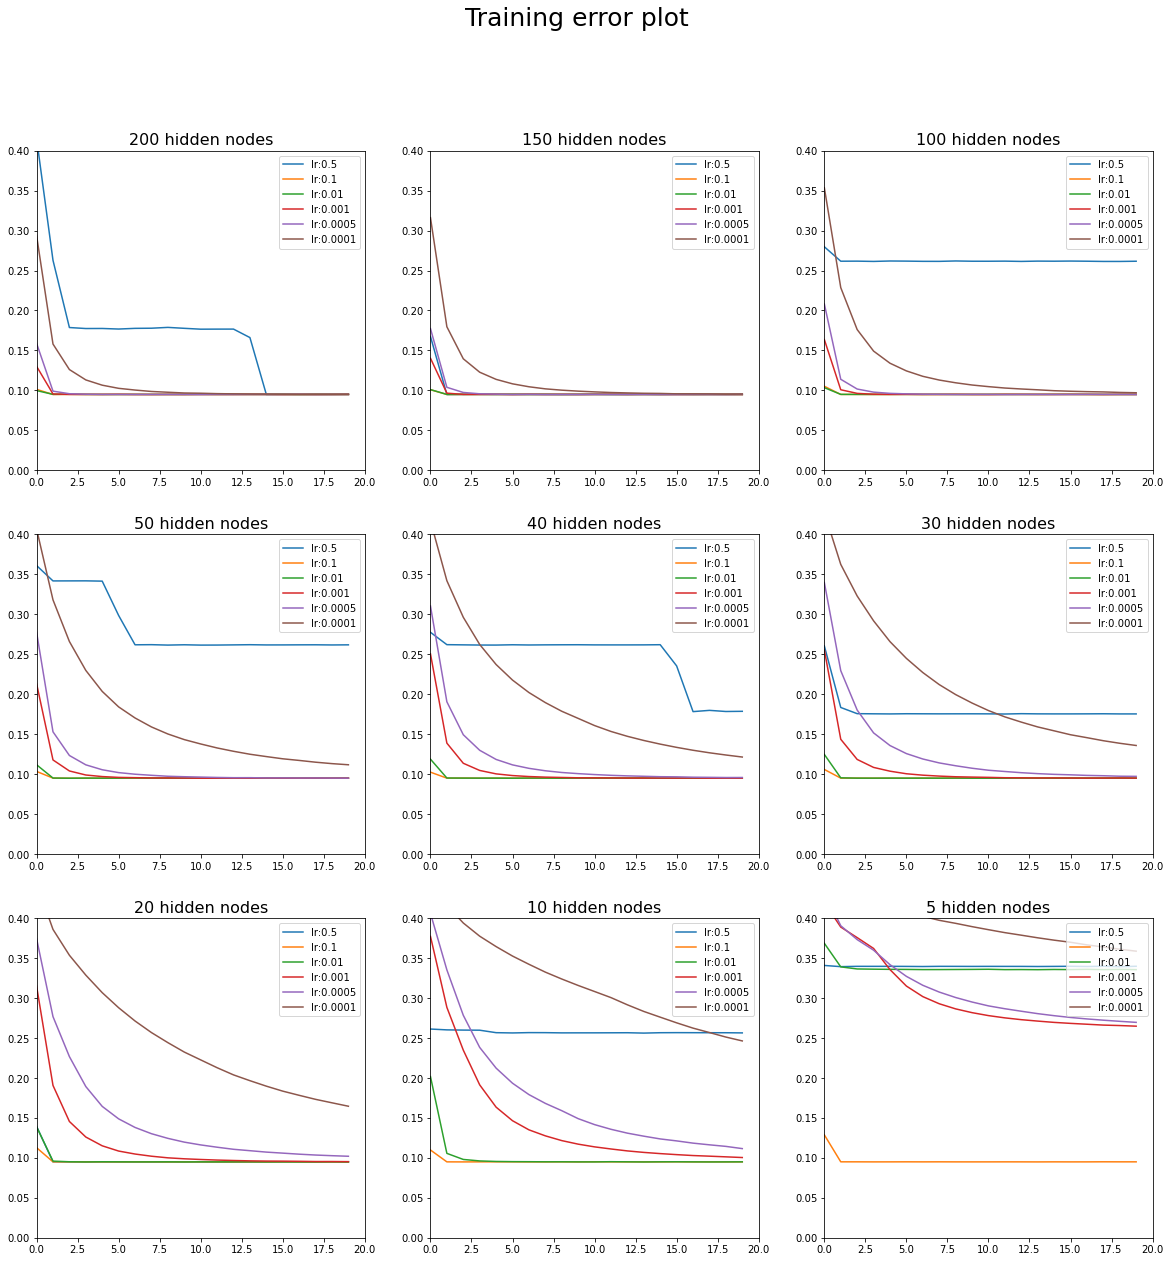

In [17]:
# Training error plot
training_error_fixed_h(20, n_hidden, learning_rate, label = "Rad_")

Da questi grafici si evince come la rete risponda bene al processo di allenamento, infatti si vede come l'MSE iterazione dopo iterazione tende a diminuire. In particolare fissato il numero di neuroni e cambiando solo il parametro d'apprendimento, l'errore diminuisce al diminuire .

Bisogna però attenzionare che valori troppo piccoli del parametro d'apprendimento potrebbero non far convergere il processo di discesa del gradiente o comunque rendono estremamente lenta la convergenza.

Scelto come valore ottimale del learning rate 0.001, procediamo con il tuning del numero di nodi nascosti.

In [38]:
def training_error_fixed_lr(best_lr,n_hidden,label = ""):
    for h in n_hidden:        
            path = "trained/"+label+"RBM_"+str(h)+"_hidden_"+str(best_lr)+"_lr_"+".csv"
            rbm_loaded = loadRBM(path)
            plt.plot(range(len(rbm_loaded.training_errors)), rbm_loaded.training_errors, label = str(h)+" hidden nodes")
            plt.legend(loc = 1)
            plt.xlim([0, 10])
            plt.ylim([0.094, 0.43])  
            
    plt.title("Error Plot")
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    
    plt.show()

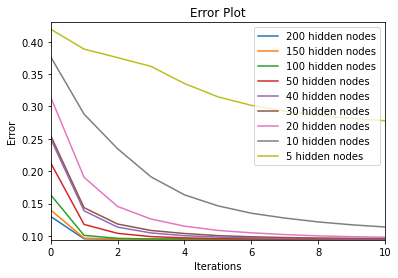

In [39]:
# Training error plot fixed lr
best_lr = 0.001
training_error_fixed_lr(best_lr, n_hidden, label="Rad_")

Analizzando il grafico possiamo affermare che la miglior RBM che possiamo allenare su questo dataset ha i seguenti parametri:
- learning rate: 0.001
- n° hidden nodes: 100

In [40]:
best_h = 100
bestRBM = RBM(n_visible = 28*28, n_hidden = best_h, n_iterations = 100, learning_rate = best_lr)
bestRBM._train(traindata)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:50<00:00,  4.10s/it]


Ora che è stato efftuato il tuning dei paramentri e quindi abbiamo ottenuto la macchina con migliori prestazioni, mettiamola alla prova nel ricostruire un pattern corrotto.


Accuracy of:  95.59 %


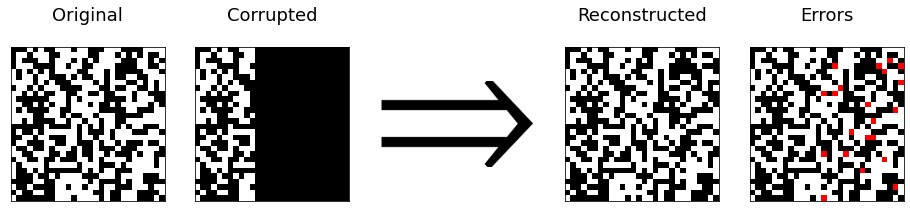

In [43]:
# Pick another random image and set some parts of the image to zero.
im_ind = 800
rest = 11
X_missing = testdata[im_ind].copy().reshape(28,28)
X_missing[:,rest:] = 0

# Image Reconstruction
rec,_,_ = reconstruction(X_missing, bestRBM , corrupted = rest)
# Apply a threshold and complete the image
X_recon = np.where(rec > 0.6*np.max(rec), 1, 0)
X_complete = X_missing.copy()
X_complete[:,rest:] = X_recon

# Highlight the differences
diff = differences(testdata[im_ind],X_complete, tot = 28*(28-rest))
# Plot the figures
plotReconstructed(testdata[im_ind], X_missing, X_complete, diff)

Utilizzando sempre la macchina precedentemente addestrata, testiamola nel ricreare un pattern dopo che i pixel di un elemento del test set sono stati flippati.


After flipping 55 % of pixels the accuracy is:  66.33 %


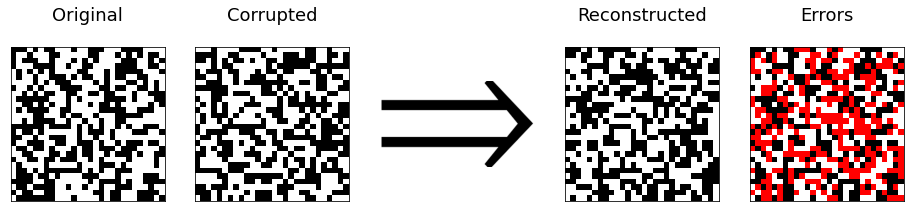


After flipping 40 % of pixels the accuracy is:  95.28 %


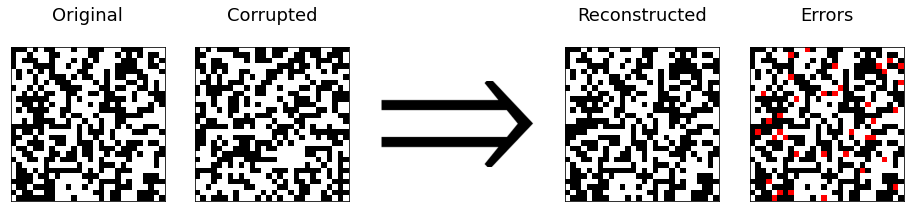

In [158]:
# Pick another random image and set some parts of the image to zero.
im_ind = 800

for perc_flip in (55,40):
    
    X_missing = flipped(perc_flip,testdata[im_ind].copy()).reshape(28,28)
    # Image Reconstruction
    rec,m,i = reconstruction(X_missing, bestRBM, archetype)
    # Apply a threshold and complete the image
    X_recon = np.where(rec > 0.5*np.max(rec), 1, 0)
    # Highlight the differences
    diff = differences(testdata[im_ind],X_recon,perc_flip)
    # Plot the figures
    plotReconstructed(testdata[im_ind], X_missing, X_recon, diff)

A seguito di queste due ricostruzioni possiamo affermare che la rete neurale addestrata svolge egreggiamente il suo lavoro tanto da riuscire a ricostruire il giusto pattern nonostante siano stati flippati un terzo dei pixel. Superata tale soglia vediamo che non è più in grado e fatica a ricreare il giusto archetipo.

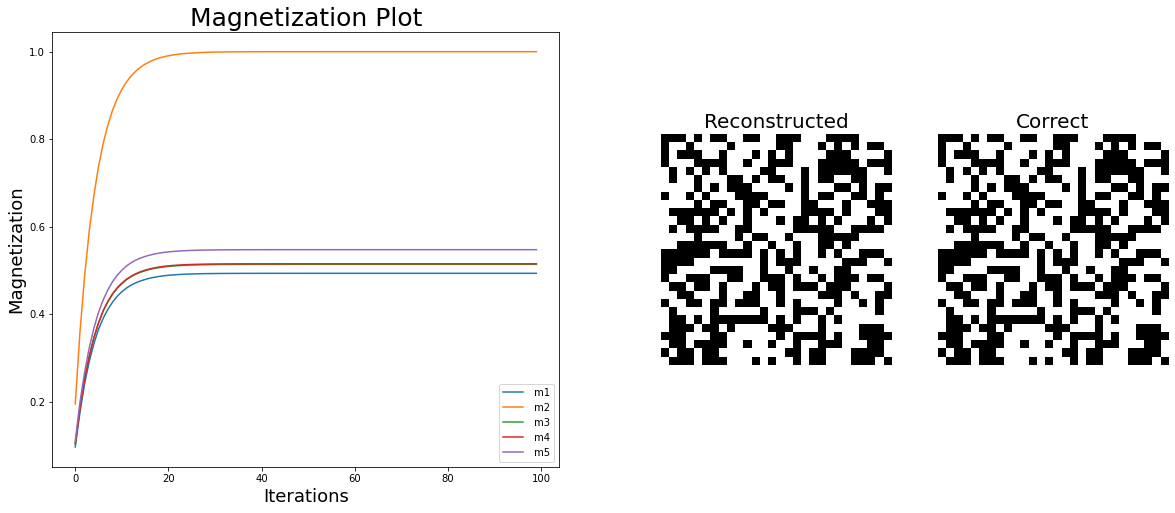

In [160]:
plot_m(m,i, archetype, X_recon)

#### Classificazione

Vediamo anche il comportamento della nostra rete neurale nel classificare i pattern.

In [162]:
n_it = [10,20,30]

for n in n_it:
    for h in n_hidden:
        acc = []
        for lr in learning_rate:
            rbm = RBM(n_visible = 28*28, n_hidden = h, n_iterations = n, learning_rate = lr, classifier = True, n_label = 5)
            rbm._train(traindata, trainlabel, classifier = True, output = True)
            rbm._save(classifier = True, label = str(n)+"_Rad_")

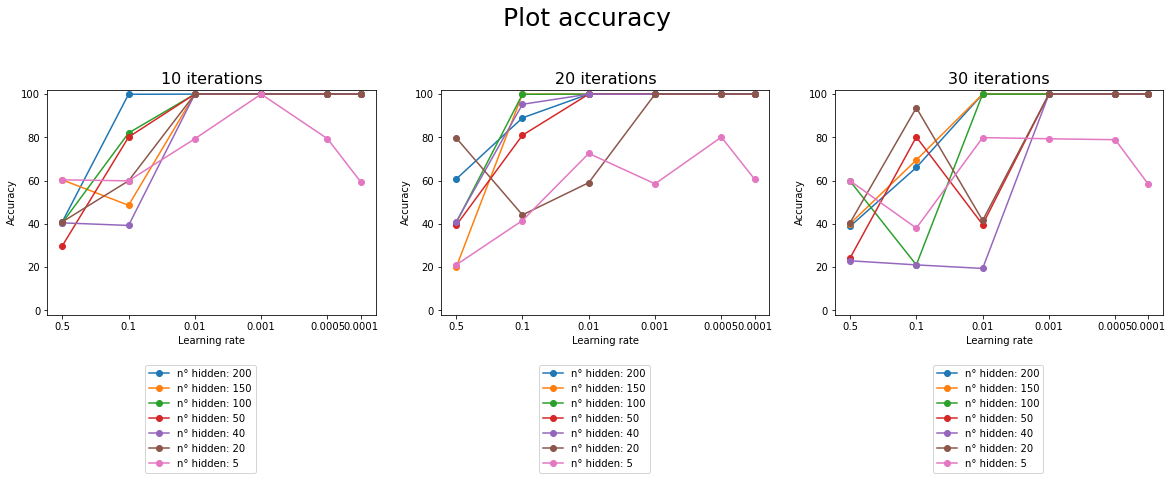

In [166]:
plotAccuracy(testdata, testlabel, learning_rate,n_hidden,n_it)

In [171]:
rbm = RBM(n_visible = 28*28, n_hidden = 100, n_iterations = 30, learning_rate = 0.01, classifier = True, n_label = 5)
rbm._train(traindata, trainlabel, classifier = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.20s/it]


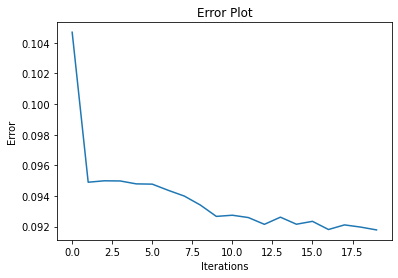

In [172]:
# Training error plot
plt.plot(range(len(rbm.training_errors)), rbm.training_errors, label = "Training Error")

plt.title("Error Plot")

plt.ylabel('Error')
plt.xlabel('Iterations')

plt.show()

Misuriamo l'accuratezza della macchina appena allenata confrontando le etichette predette dalla rete con quelle del test set e successivamente stampiamone dei risulati.

In [173]:
acc = 0
k = rbm._predict(testdata)
for i in range(len(testlabel)):
    if k[i] == testlabel[i]:
        acc += 1
        
print("Accuracy: ",round(acc/len(testlabel)*100,2),"%")

Accuracy:  100.0 %


### MNIST dataset

Conclusa con successo l'analisi effuata sulle variabili Rademacher, proviamo lo stesso approccio con un dataset più articolato quale il MNIST, una banca dati contenente 70 mila immagini di 28x28 pixel di cifre scritte a mano.

In [1]:
from utils_function import *

train_data = pd.read_csv('C:/Users/ASUS/Desktop/Python/Università/MRN/data/mnist_test.csv', delimiter = ',')
test_data = pd.read_csv('C:/Users/ASUS/Desktop/Python/Università/MRN/data/mnist_test.csv', delimiter = ',')

label = 10

traindata = np.array([grayToBlack(img,0.4) for img in np.asfarray(train_data)[:,1:]])
testdata = np.array([grayToBlack(img,0.4) for img in np.asfarray(test_data)[:,1:]])
    
trainlabel = np.array(train_data)[:,0]
testlabel = np.array(test_data)[:,0]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 58.25it/s]


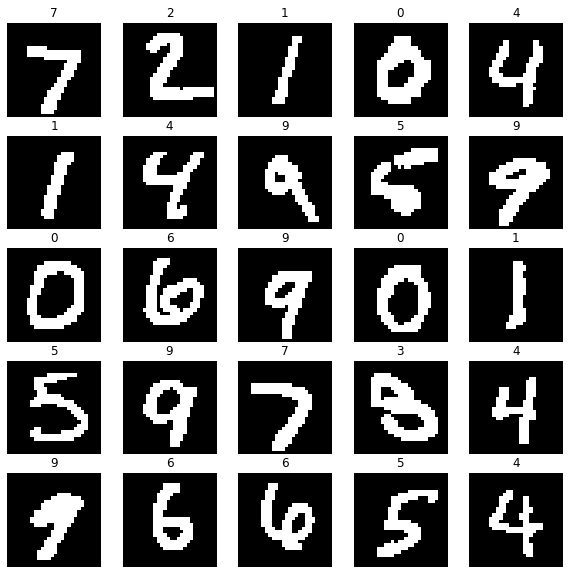

In [2]:
plt.figure(figsize=(10, 10))

for i in tqdm(range(25)):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(traindata[i].reshape((28, 28)), cmap='gray')
    plt.title(trainlabel[i])
    plt.axis('off')
        
plt.show()
plt.close()

In [175]:
for h in n_hidden:
    for lr in learning_rate:
        rbm = RBM(n_visible = 28*28, n_hidden = h, n_iterations = 20, learning_rate = lr)
        rbm._train(traindata, output = True)
        rbm._save(label = "MNIST_")

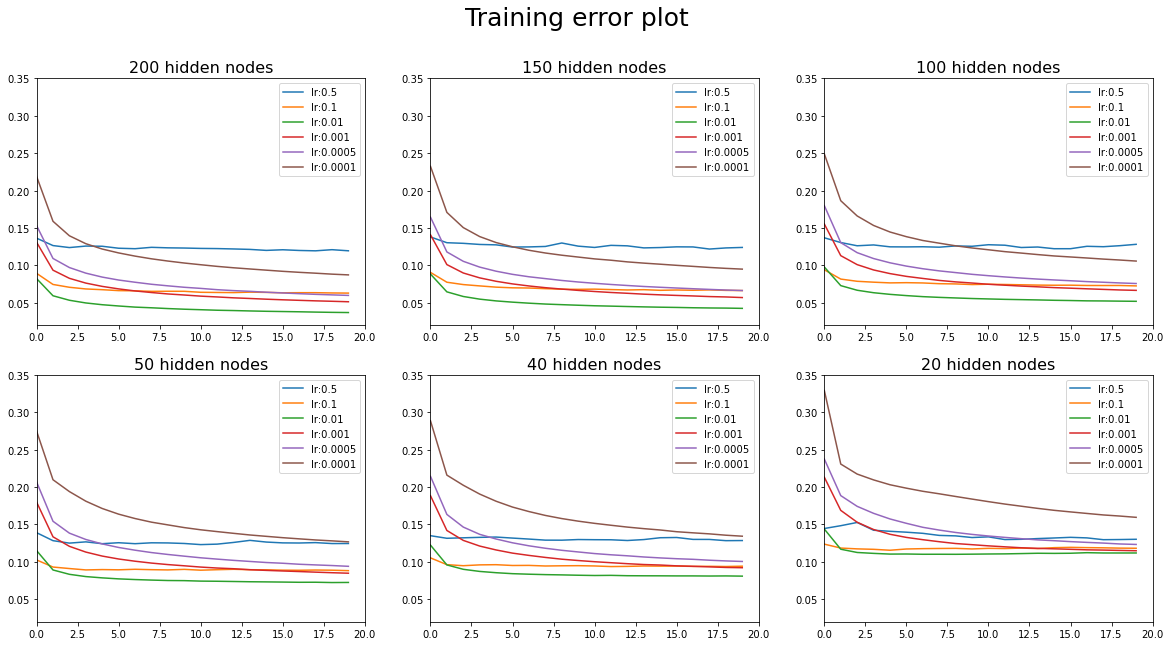

In [196]:
# Training error plot
training_error_fixed_h(20,n_hidden,learning_rate,label="MNIST_")

In [3]:
import time 

rbm = RBM(n_visible = 28*28, n_hidden = 10, n_iterations = 70, batch_size = 1, learning_rate = 0.005)
rbm._train(np.array(traindata[23], ndmin = 2))

gen_imgs = rbm.training_reconstructions
fig = plt.figure()

x = [img.reshape((28,28)) for img in gen_imgs]
im = plt.imshow(x[0], animated = False, cmap = 'gray')
plt.close()

def updatefig(j):
    im.set_array(x[j])
    return im,

anim = animation.FuncAnimation(fig = fig, func = updatefig, frames = len(x) if len(x)<60 else 70, interval = 50, blit = True);
display(HTML(anim.to_jshtml(default_mode = "once")));
time.sleep(0.5)
Javascript('document.querySelector(".anim-buttons > button:nth-child(6)").click()')

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 5856.21it/s]


<IPython.core.display.Javascript object>

In [1111]:
bestRBM_M = RBM(n_visible = 28*28, n_hidden = 200, n_iterations = 100, learning_rate = 0.01)
bestRBM_M._train(traindata, output=False)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:31<00:00,  3.92s/it]


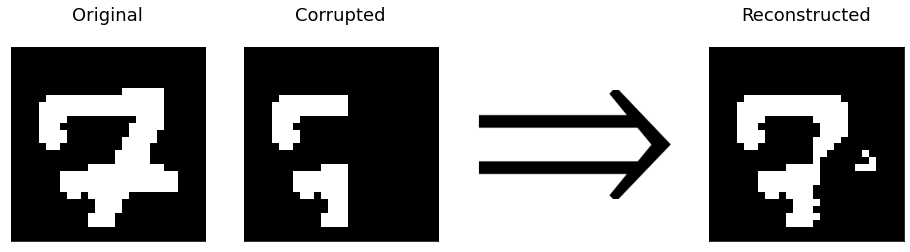

In [1532]:
# Pick another random image and set some parts of the image to zero.
im_ind = 810
rest = 15
X_missing = testdata[im_ind].copy().reshape(28,28)
X_missing[:,rest:] = 0

# Image Reconstruction
rec = reconstruction(X_missing, bestRBM_M , corrupted = rest)
# Apply a threshold and complete the image
X_recon = np.where(rec > 0.6*np.max(rec), 1, 0)
X_complete = X_missing.copy()
X_complete[:,rest:] = X_recon

# Plot the figures
plotReconstructed(testdata[im_ind], X_missing, X_complete)

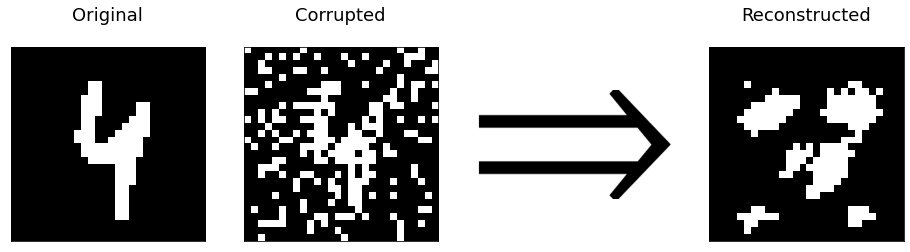

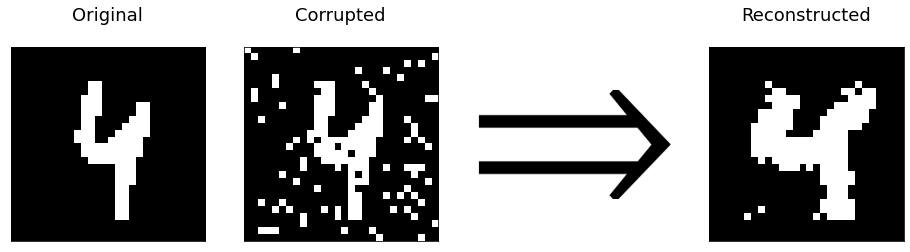

In [1545]:
# Pick another random image and set some parts of the image to zero.
im_ind = 116
    
for perc_flip in (20,10):
    X_missing = flipped(perc_flip,testdata[im_ind].copy()).reshape(28,28)
    # Image Reconstruction
    rec = reconstruction(X_missing, bestRBM_M)
    # Apply a threshold and complete the image
    X_recon = np.where(rec > 0.5*np.max(rec), 1, 0)
    # Plot the result
    plotReconstructed(testdata[im_ind], X_missing, X_recon)

#### Classificazione

In [3]:
for n in n_it:
    for h in n_hidden:         
        acc = []
        for lr in learning_rate:
            rbm = RBM(n_visible = 28*28, n_hidden = h, n_iterations = n, learning_rate = lr, classifier = True, n_label = 10)
            rbm._train(traindata, trainlabel, classifier = True, output = True)
            rbm._save(classifier = True, label = str(n)+"_MNIST_")

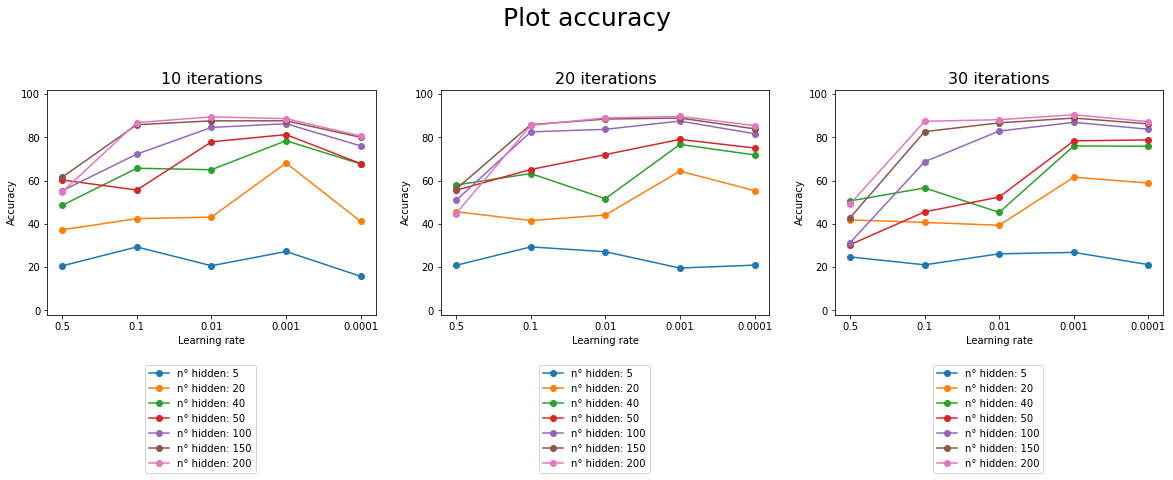

In [8]:
plotAccuracy(testdata, testlabel,learning_rate,n_hidden,n_it,label = "_MNIST_")

In [9]:
rbm = RBM(n_visible = 28*28, n_hidden = 200, n_iterations = 100, learning_rate = 0.01, classifier = True, n_label = label)
rbm._train(traindata, trainlabel, classifier = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:15<00:00, 15.77s/it]


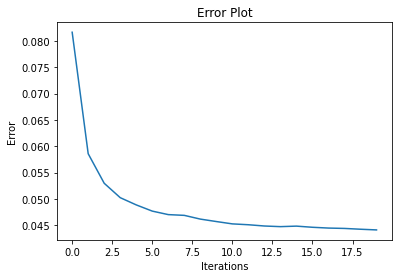

In [10]:
# Training error plot
plt.plot(range(len(rbm.training_errors)), rbm.training_errors, label = "Training Error")

plt.title("Error Plot")

plt.ylabel('Error')
plt.xlabel('Iterations')

plt.show()

In [13]:
acc = 0
k = rbm._predict(testdata)
for i in range(len(testlabel)):
    if k[i] == testlabel[i]:
        acc += 1
        
print("Accuracy: ",round(acc/len(testlabel)*100,2),"%")

Accuracy:  88.79 %


In [15]:
acc = 0
k = rbm._predictF_E(testdata)
for i in range(len(testlabel)):
    if k[i] == testlabel[i]:
        acc += 1
        
print("Accuracy: ",round(acc/len(testlabel)*100,2),"%")

Accuracy:  82.06 %


## Referenze

- E. Agliari, Dispense corso Modelli di Reti Neurali
- A. Fischer, C. Igel, [An Introduction to Restricted Boltzmann Machines]( https://link.springer.com/content/pdf/10.1007/978-3-642-33275-3_2.pdf)
- G. Hinton, [A Practical Guide to Training Restricted Boltzmann Machines]( https://www.csrc.ac.cn/upload/file/20170703/1499052743888438.pdf)
- S. Cherla, S. N. Tran, T. Weyde and A. Garcez, [Generalising the Discriminative Restricted Boltzmann Machine]( https://arxiv.org/pdf/1604.01806.pdf)
- G. Hinton, T. Schmah, R. S. Zemel and S. L. Small, [Generative versus discriminative training of RBMs for classification of fMRI images]( https://www.cs.toronto.edu/~fritz/absps/fmrinips.pdf)
- H. Larochelle, Y. Bengio, [Classification using Discriminative Restricted Boltzmann Machines]( https://www.researchgate.net/profile/Hugo-Larochelle/publication/221346359_Classification_using_discriminative_restricted_Boltzmann_machines/links/00b495214faee4fc51000000/Classification-using-discriminative-restricted-Boltzmann-machines.pdf?origin=publication_detail)